In [2]:
import gym  # type: ignore 
#from gym import spaces  # type: ignore
import torch # type: ignore
import torch.nn.functional as F  # type: ignore
import numpy as np   # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import rl_utils 

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [4]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr) 
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)   # 动作概率分布

        action_dist = torch.distributions.Categorical(probs)
        
        action = action_dist.sample()

        return action.item()
    

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))  #在维度1（列方向）选取actions指定的索引对应的概率，即实际执行的每个动作的概率
        actor_loss = torch.mean(-log_probs * td_delta.detach())  #detach() 用于 阻断梯度传播，防止 TD 误差影响 Critic 网络 的参数更新，保证Critic仅由critic_loss 进行更新
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))  #td_target 本身是由 Critic 计算出来的，所以它 包含 Critic 网络的计算图，如果不 detach()，它的梯度可能会影响 Critic 网络的学习，我们希望让td_target.detach()只是个常量
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [6]:
class CloudEdgeEnv(gym.Env):
    def __init__(self, num_edges=2):
        super(CloudEdgeEnv, self).__init__()

        self.num_edges = num_edges
        self.task_count = 0
        self.max_tasks = 200

        self.task_size = 0

        # 计算能力（单位任务/秒）：Cloud > Edge1 > Edge2
        self.compute_speeds = np.array([100, 80, 5])

        # 基础网络带宽（Mbps）
        self.base_bandwidths = np.array([1, 100, 20])

        # 状态空间：[任务大小] + [网络带宽]
        self.observation_space = gym.spaces.Box(
            low=0, high=100, shape=(1 + num_edges,), dtype=np.float32  # 任务大小 + 2个边缘设备的带宽
        )

        # 动作空间：0 (云端) 或 1~num_edges (某个边缘设备)
        self.action_space = gym.spaces.Discrete(num_edges + 1)

    def reset(self):
        self.task_size = np.random.randint(0, 100)  # 任务大小
        self.bandwidths = np.random.uniform(0.8 * self.base_bandwidths, 1.2 * self.base_bandwidths)  # 带宽波动
        return self._get_state()

    def _get_state(self):
        return np.concatenate(([self.task_size], self.bandwidths[:self.num_edges]))

    def step(self, action):
        # 任务大小不变，使用 reset 里的 self.task_size
        compute_time = self.task_size / self.compute_speeds[action]  # 计算时间

        if action == 0:  # 任务分配给云端
            transmission_time = 100 / self.bandwidths[0]  # 传输时间
            delay = transmission_time + compute_time  # 总延迟
            reward = -delay  # 惩罚延迟

        else:  # 任务分配到某个边缘
            edge_index = action - 1
            transmission_time = 100 / self.bandwidths[edge_index + 1]
            delay = transmission_time + compute_time
            reward = -delay  # 惩罚延迟
        
        self.task_count += 1
        done = self.task_count >= self.max_tasks
        if done:
            self.task_count = 0
        return self._get_state(), reward, done, {}


In [7]:
# 训练参数
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98  # 奖励折扣
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 使用 CloudEdgeEnv 作为环境
num_edges = 2  # 设定边缘设备数量
env = CloudEdgeEnv(num_edges)

# 获取状态维度和动作维度
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 创建 Actor-Critic 智能体
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

# 训练智能体, stop here 
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\10600\AppData\Local\Temp\ipykernel_15720\2984794896.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s, episode=500, return=-322.434]


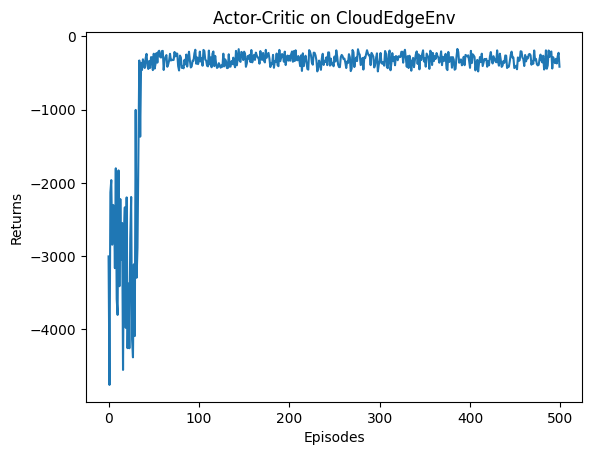

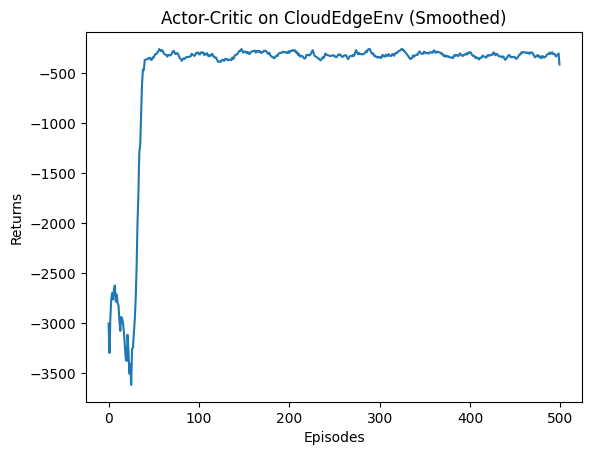

In [8]:
# 绘制训练曲线
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on CloudEdgeEnv')
plt.show()

# 计算平滑曲线
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on CloudEdgeEnv (Smoothed)')
plt.show()